In [153]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")


In [154]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)
# 计算data的方差的函数

In [155]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

# 1. Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates. 

$y_i=\tau*T_i+β'*x+e_i$

 
### τ is a treatment effect and x is covariate (there is no confounder)




In [156]:
#simulate DGP with only co

def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+1 # 1 confounder 
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # 把conf_mult设置为0也即没有confounder
    else:
        conf_mult = 1 # 则conf_mult为1则包含confounder
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err  #计算Y的函数，包含了covariates
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
 
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    
    """
    tau是treatment effect
    Nrange是sample size的大小
    p是生成的covariates数量
    p0是covariates包含的数量
    corr是covariates之间的correlation大小
    conf是confounder有没有
    
    """
    
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            # 不加入covariates
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    # 作图plot x against y
    # lable is what comes out in the legend
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    # axhline是真实tau值的水平线
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    # 下边lb和ub是画置信区间
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()


In [157]:
tau = 3          # treatment effect的系数
corr = .5            # -corr: Correlation for multivariate normal
conf=False           # -conf: Indicating the existence of confounding factors
p = 4
p0 = 4 # number of covariates used in the DGP 
flagX=1
N = 1000 
Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
data = np.hstack([Y,T,X])
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'X1', 'X2','X3','X4']
data.to_csv('data1.csv')
data

,Y,T,X1,X2,X3,X4
0,23.462507,1.0,1.722734,-0.256492,-0.018585,0.723544
1,-15.753012,0.0,-1.405111,-0.787193,-2.246144,-1.516214
2,17.762221,0.0,0.934260,0.600883,0.120291,1.087728
3,-5.067987,0.0,-0.116100,-0.802189,-0.811635,-0.535862
4,18.478247,1.0,1.697125,-0.238427,0.594738,0.875866
...,...,...,...,...,...,...
995,-11.096936,1.0,-0.490086,-1.509822,-1.106811,-0.949469
996,1.758564,0.0,-0.073309,-0.235437,-0.240900,0.391273
997,-33.878952,0.0,-2.118605,-2.093770,-1.095439,-1.178951
998,-16.804994,1.0,-0.741964,-2.003403,-0.589785,-0.868920


## illustrate DGP with a DAG


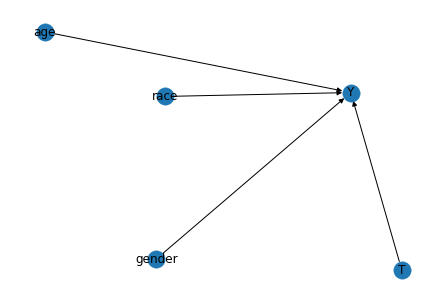

In [159]:
g = nx.DiGraph()

g.add_node('s1', desc='Y')
g.add_node('s2', desc='gender')
g.add_node('s3', desc='race')
g.add_node('s4', desc='age')
g.add_node('s5', desc='T')

g.add_edge('s2','s1')
g.add_edge('s3','s1')
g.add_edge('s4','s1')
g.add_edge('s5','s1')
 
pos = nx.spring_layout(g)
nx.draw(g, pos)
node_labels = nx.get_node_attributes(g, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

# Monte Carlo 
## Case a ( covariates not controlled )


In [149]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,4,4,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }


100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 202.61it/s]


In [150]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.07210192755462753, RMSE=3.8342702739275487, size=0.056
N=1000: bias=0.01681163647640305, RMSE=1.1354312075547441, size=0.043


# Case b (covariates controlled)


In [147]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,4,4,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }


100%|██████████████████████████████████████| 2000/2000 [00:11<00:00, 176.85it/s]


In [148]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0017636451403265439, RMSE=0.14741752073767123, size=0.053
N=1000: bias=0.0015440932310268303, RMSE=0.04478323029587996, size=0.049


Explainning of reuslt: as N from 100 to 1000 , RMSE becomes smaller. Also, as we controlled the covariates, the RMSE decrease. 

Example of a real-life situation that might be consisitent with the DGP

#### We are researching the factors that influence peoples' income. In order to do this, we assue personal income is our dependent variable (Y), and education level as our treatment ( if people who have higher than college education is 1, and if not is 0). Covairates are gender, race, age, and major. 


# Simulate a DGP with a con founder 


$y_i=3*T_i+0.2*Confounder_i+e_i$

$T_i=0.2*Confounder_i+u_i$

In [213]:
def fn_generate_data_conf(tau,N,p,corr):

    nvar = p+1 # 1 confounder and variable for randomizing treatment
    corr = 0.2 # correlation for multivariate normal
    X = fn_generate_multnorm(N,corr,nvar)
    C = X[:,1].reshape([N,1]) # confounder
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    Yab = tau*T+0.2*C+err
    Tab = err+0.2*C

    return (Yab,T,C)

In [216]:
tau = 2
corr =0.2
p = 3
Y,T,C = fn_generate_data_conf(tau,N,p,corr)
data = np.hstack([Y,T,C])
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'C']
data.to_csv('data2.csv')
data


,Y,T,C
0,2.623821,0.623821,0.101875
1,-0.586954,-0.586954,1.392417
2,-1.106002,-1.106002,-0.153773
3,2.281588,0.281588,0.788331
4,0.189836,0.189836,-0.981018
...,...,...,...
995,1.609313,-0.390687,-2.137904
996,1.112907,1.112907,1.588747
997,1.276638,-0.723362,-0.277114
998,-0.042667,-0.042667,0.273068


# illustrate a DAP 

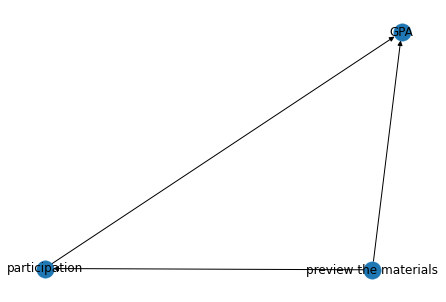

In [210]:
G = nx.DiGraph()
    
G.add_node('s1', desc='GPA')
G.add_node('s2', desc='participation')
G.add_node('s3', desc='preview the materials')
G.add_edge('s2','s1')
G.add_edge('s3','s2')
G.add_edge('s3','s1')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

## Monte Carlo
### Case a ( control for the confounder)


In [217]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T,C],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }


100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 184.43it/s]


In [218]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-1.0003087250815506, RMSE=1.010818638109642, size=1.0
N=1000: bias=-0.9991097734475622, RMSE=1.0000824299799618, size=1.0


### Case b ( not control for the confounder)

In [233]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 192.31it/s]


In [234]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.8001362180707193, RMSE=0.80025947528443, size=1.0
N=1000: bias=0.8000062315751263, RMSE=0.8000183362348193, size=1.0


### example of real-life 
We studying how participation will affact students' GPA. Y= GPA
Confounder= preview the material. 
we will find that students who had preview the material will more likely answer question (particiation), also they are more likely reciving a higher GPA. 

# Simulate a DGP with selection bias into the treatment 

$S = 0.2*y+0.3*T_i+u$

$y = 0.2*T+e$

In [230]:
def fn_generate_data_s(tau,N,p,corr):

    nvar = p+1 # 1 for selection bias
    corr = 0.3 # correlation for multivariate normal
 
    allX = fn_generate_multnorm(N,corr,nvar)
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    U = np.random.normal(0,1,[N,1])
    Y = tau*T+err
    S = 0.2*T+0.3*Y+U

    return (Y,T,S)

In [239]:
tau = 0.2
corr = 0.3
p = 3
N = 1000
Y,T,S = fn_generate_data_s(tau,N,p,corr)

data4 = np.hstack([Y,T,C])
data4 = pd.DataFrame(data)
data.columns = ['Y', 'T', 'S']
data.to_csv('data4.csv')
data

,Y,T,S
0,2.623821,0.623821,0.101875
1,-0.586954,-0.586954,1.392417
2,-1.106002,-1.106002,-0.153773
3,2.281588,0.281588,0.788331
4,0.189836,0.189836,-0.981018
...,...,...,...
995,1.609313,-0.390687,-2.137904
996,1.112907,1.112907,1.588747
997,1.276638,-0.723362,-0.277114
998,-0.042667,-0.042667,0.273068


# illustration DGP with a DAG

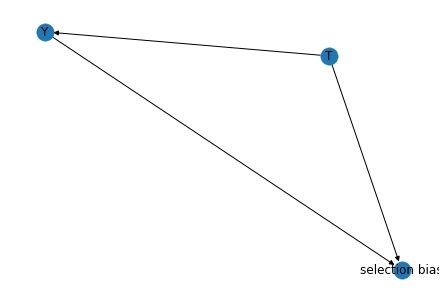

In [232]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Y')
G.add_node('s2', desc='T')
G.add_node('s3', desc='selection bias')
G.add_edge('s2','s1')
G.add_edge('s1','s3')
G.add_edge('s2','s3')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

## Monte Carlo
### Case a ( control  ) 

In [240]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Zexp = fn_generate_data_s(tau,N,p,corr)
        covars = np.concatenate([T,Zexp],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:11<00:00, 178.12it/s]


In [241]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')


N=100: bias=-0.07609318788268829, RMSE=0.15452549080501485, size=0.08
N=1000: bias=-0.0734797201138797, RMSE=0.0854051009481212, size=0.393


### Case b ( not control )

In [242]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Zab = fn_generate_data_s(tau,N,p,corr)   
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 210.16it/s]


In [243]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.004122688629063437, RMSE=0.2048462030210417, size=0.058
N=1000: bias=-0.0005866415196693371, RMSE=0.06214333008299138, size=0.048


## Example in real-life 

we want to assess a program for improving the eating habits of shift workers. You put up flyers where many work night shifts and invite them to participate. However, those who sign up may be very different from those who don’t. They may be more health conscious to begin with, which is why they are interested in a program to improve eating habits.

y = assessment grade  

s = only signed up people

T = Varieties of dishes
